![Задача](task.png)

решить её методом стрельбы И методом квазилинеаризации Ньютона (проверить сходимость решения по расчетной сетке).

# Метод стрельбы

1. Задать начальное предположение для y’(0) —  s.

2. Решить задачу Коши для уравнения y'' + sin y = 0 с начальными условиями y(0)=0, y’(0)=s на интервале [0, x_k].

3. Проверить, насколько решение в точке x_k близко к pi.

4. Использовать метод Ньютона или другой итерационный метод для корректировки s, чтобы минимизировать разницу между y(x_k) и pi.

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Для решения задачи Коши - метод Рунге-Кутты:
# y’ = z
# z’ = -sin y
# Тогда система будет:
# dy/dx = z
# dz/dx = -sin y 

def rk4_system(y0, z0, xk, N):
    h = xk / N
    x = [0]
    y = [y0]
    z = [z0]
    for _ in range(N):
        k1_y = h * z[-1]
        k1_z = h * (-np.sin(y[-1]))
        
        k2_y = h * (z[-1] + 0.5*k1_z)
        k2_z = h * (-np.sin(y[-1] + 0.5*k1_y))
        
        k3_y = h * (z[-1] + 0.5*k2_z)
        k3_z = h * (-np.sin(y[-1] + 0.5*k2_y))
        
        k4_y = h * (z[-1] + k3_z)
        k4_z = h * (-np.sin(y[-1] + k3_y))
        
        new_y = y[-1] + (k1_y + 2*k2_y + 2*k3_y + k4_y)/6
        new_z = z[-1] + (k1_z + 2*k2_z + 2*k3_z + k4_z)/6
        
        x.append(x[-1] + h)
        y.append(new_y)
        z.append(new_z)
    return np.array(x), np.array(y)


def shoot(s, xk, N=1000):
    x, y = rk4_system(0, s, xk, N)
    return y[-1]

def newton_shooting(xk, s0=1.0, tol=1e-9, max_iter=100):
    s = 2

    for _ in range(max_iter):
        F = shoot(s, xk) - np.pi
        delta_s = 1e-6
        F_plus = shoot(s + delta_s, xk)
        F_deriv = (F_plus - np.pi - F) / delta_s
        if abs(F_deriv) < 1e-12:
            break
        ds = -F / F_deriv
        s += ds
        if abs(ds) < tol:
            break
    return s

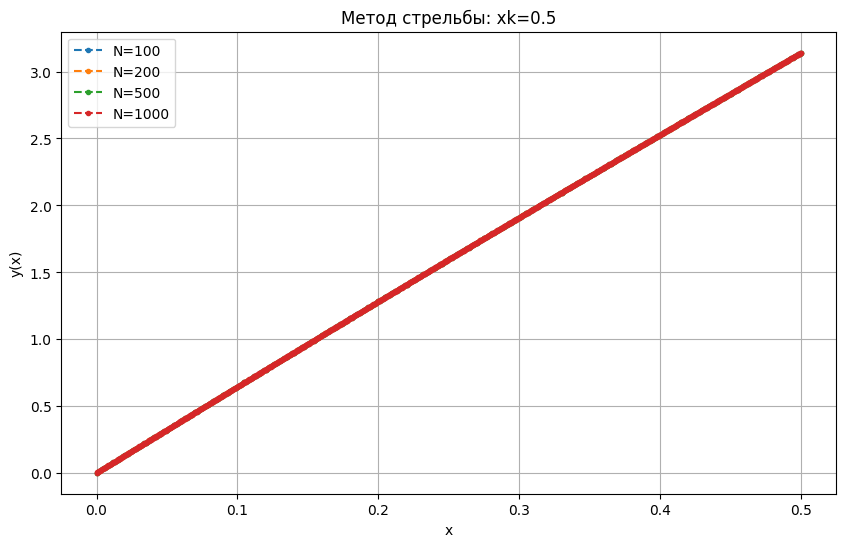

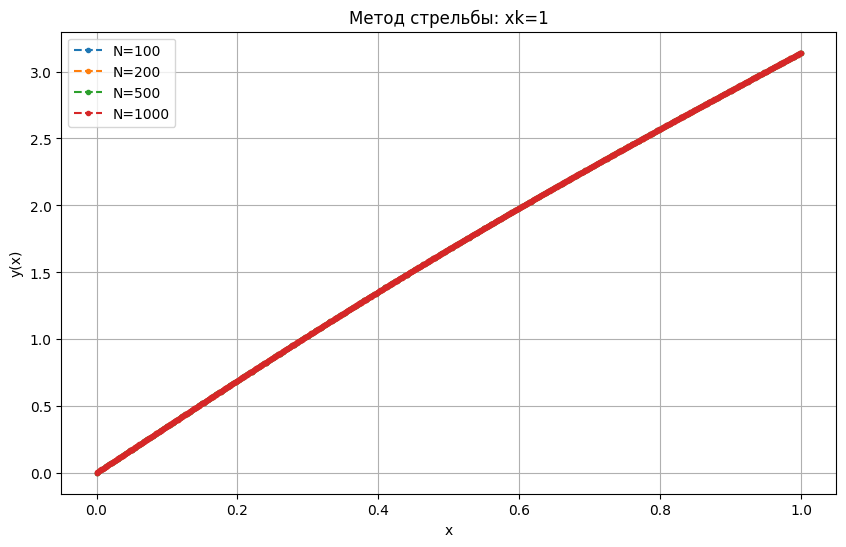

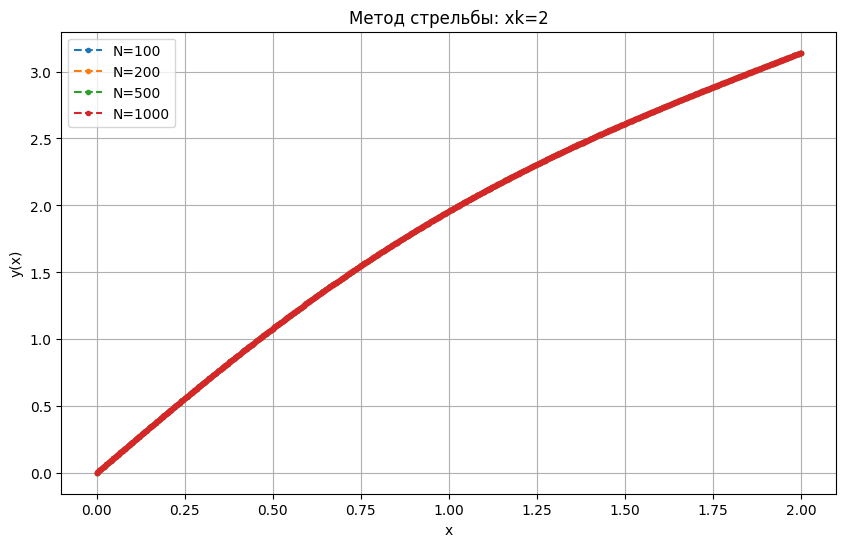

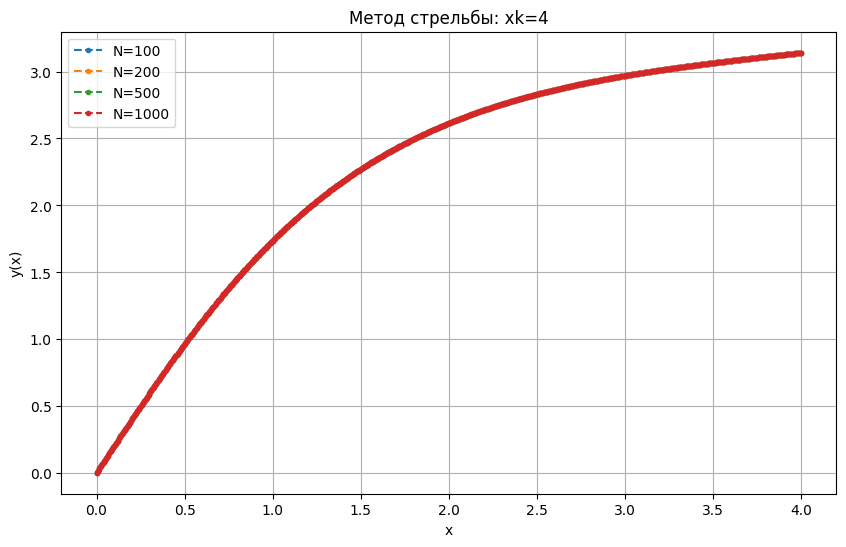

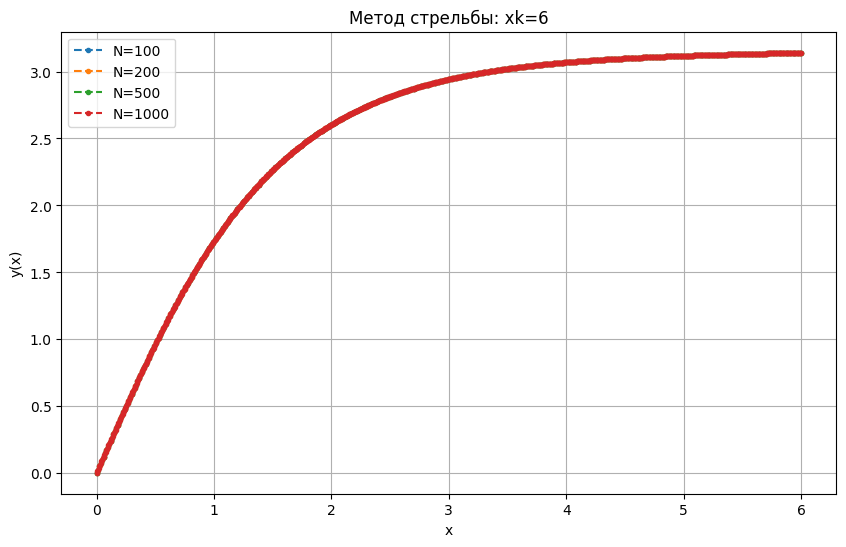

In [42]:
def plot_shooting(xk, N_values=[100, 200, 400]):
    s_opt = newton_shooting(xk)
    plt.figure(figsize=(10, 6))
    for N in N_values:
        x, y = rk4_system(0, s_opt, xk, N)
        plt.plot(x, y, '--o', markersize=3, label=f'N={N}')
    plt.title(f'Метод стрельбы: xk={xk}')
    plt.xlabel('x')
    plt.ylabel('y(x)')
    plt.legend()
    plt.grid(True)
    plt.show()

for xk in [0.5, 1, 2, 4, 6]:
    plot_shooting(xk, N_values=[100, 200, 500, 1000])

# Ньютона

In [54]:
# метод прогонки Томаса для трёхдиагональных систем
def thomas(a, b, c, d):
    n = len(d)
    c_ = np.zeros(n-1)
    d_ = np.zeros(n)
    c_[0] = c[0] / b[0]
    d_[0] = d[0] / b[0]
    for i in range(1, n-1):
        denom = b[i] - a[i-1] * c_[i-1]
        c_[i] = c[i] / denom
        d_[i] = (d[i] - a[i-1] * d_[i-1]) / denom
    d_[-1] = (d[-1] - a[-1] * d_[-2]) / (b[-1] - a[-1] * c_[-1])
    x = np.zeros(n)
    x[-1] = d_[-1]
    for i in range(n-2, -1, -1):
        x[i] = d_[i] - c_[i] * x[i+1]
    return x

def quasilinear_newton(xk, N=100, tol=1e-6, max_iter=100):
    h = xk / N
    x = np.linspace(0, xk, N+1)
    y = np.linspace(0, np.pi, N+1)  

    for _ in range(max_iter):
        a = np.zeros(N-1)  
        b = np.zeros(N-1)  
        c = np.zeros(N-1)  
        d = np.zeros(N-1)  

        for i in range(1, N):
            idx = i-1
            y0_second_deriv = (y[i+1] - 2*y[i] + y[i-1]) / h**2
            a[idx] = 1 / h**2 if idx > 0 else 0 
            b[idx] = -2 / h**2 + np.cos(y[i])
            c[idx] = 1 / h**2 if idx < N-2 else 0 
            d[idx] = (-np.sin(y[i])) - y0_second_deriv

        v_internal = thomas(a, b, c, d)  

        v = np.concatenate([[0], v_internal, [0]])  

        y_new = y + v

        if np.max(np.abs(v)) < tol:
            break
        y = y_new.copy()

    return x, y

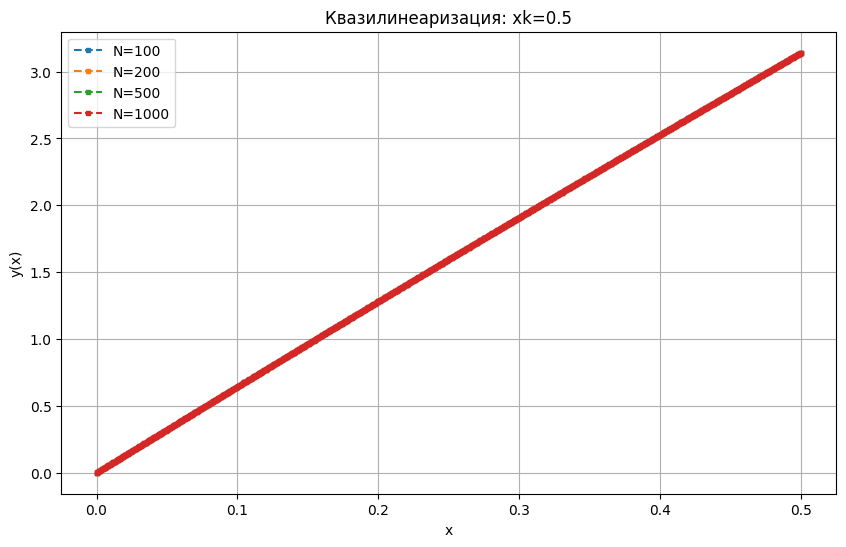

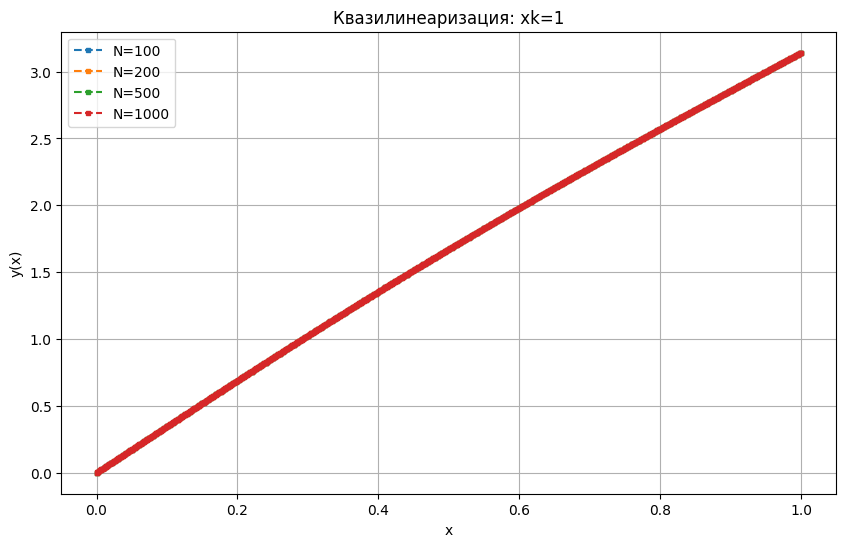

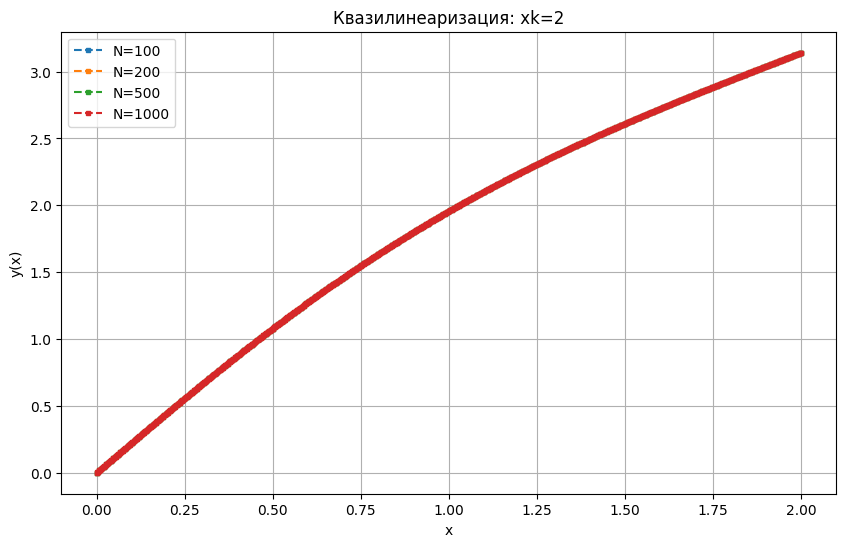

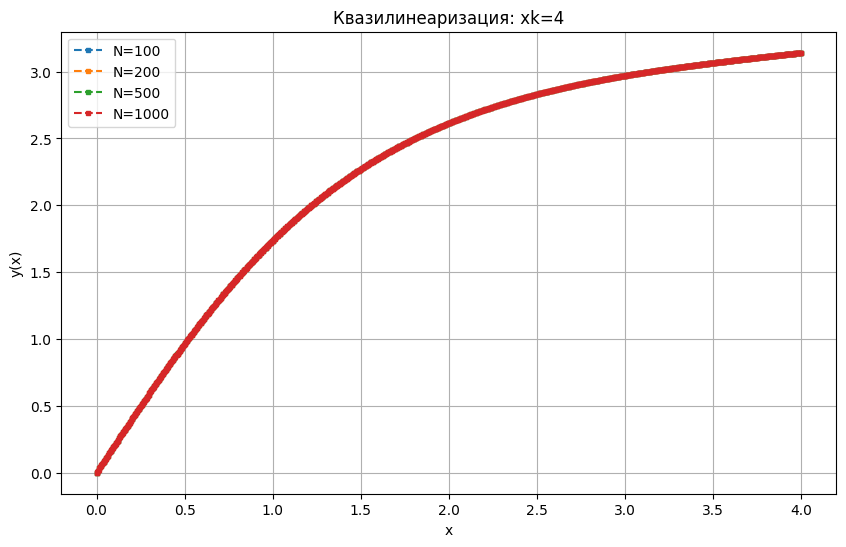

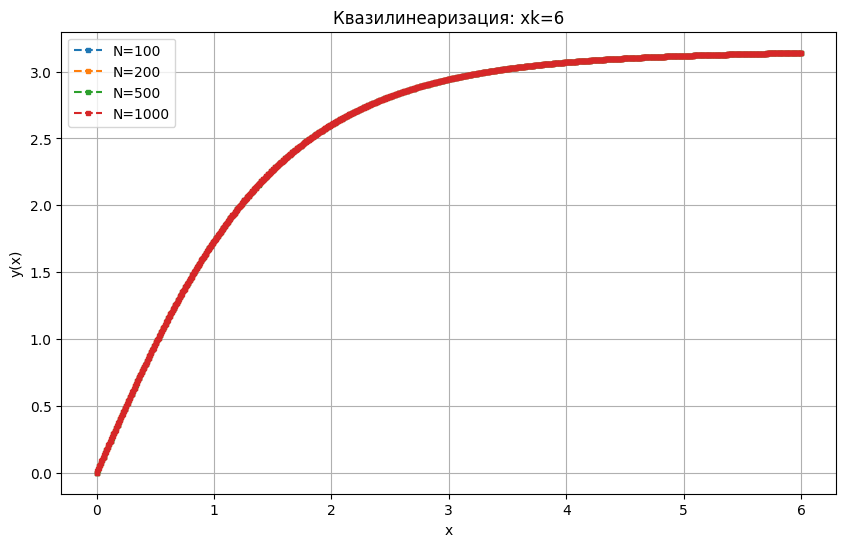

In [53]:
def plot_quasilinear(xk, N_values=[50, 100, 200]):
    plt.figure(figsize=(10, 6))
    for N in N_values:
        x, y = quasilinear_newton(xk, N=N)
        plt.plot(x, y, '--s', markersize=3, label=f'N={N}')
    plt.title(f'Квазилинеаризация: xk={xk}')
    plt.xlabel('x')
    plt.ylabel('y(x)')
    plt.legend()
    plt.grid(True)
    plt.show()

for xk in [0.5, 1, 2, 4, 6]:
    plot_quasilinear(xk, N_values=[100, 200, 500, 1000])